## FastApi

👉 High performance python framework

👉 Easy to learn, fast to code

👉 Automatically generated documentation allowing to test the API endpoints easily 🎉

https://fastapi.tiangolo.com/

In [ ]:
!pip install fastapi

### Root entry point

FastAPI uses python decorators in order to link the routes that the developers will query to the code of the endpoints. The code of the decorated function will be called whenever a HTTP request is received. The response will be returned as a JSON object to the code querying the API.

In [ ]:
from fastapi import FastAPI

app = FastAPI()

# define a root `/` endpoint
@app.get("/")
def index():
    return {"ok": True}

What if we run the code?

python -m simple

Nothing happens... 🤔

We need to use a web server in order to listen to the web requests for the API and call the code of the corresponding endpoint !

👉 We will use Uvicorn

## Uvicorn

👉 Lightning fast web server for python

👉 Uvicorn listens to all the HTTP requests and calls the code decorated for the corresponding FastAPI endpoints.

https://www.uvicorn.org/

In [ ]:
!pip install uvicorn

### Let's run our API using the web server

Uvicorn requires as parameters the name of the python file to run (here simple.py) as well as the name of the variable inside of the file containing the instance of the FastAPI app (here the variable is called app, hence the supplied parameter simple:app).

In [ ]:
!uvicorn simple:app --reload

Now we can browse to the root page of the API: http://localhost:8000/

### Documentation and tests

FastAPI provides automatically generated documentation allowing developers to simplify their integration of the API. The endpoints of the API can be easily tested through dedicated pages 🎉

Swagger documentation and tests:

    http://localhost:8000/docs

Redoc documentation:

    http://localhost:8000/redoc

👉 The /docs endpoint is powered by Swagger and comes in very handy in order to test our API and verify that everything is working correctly. It is also very useful for developers wanting to test our API

### Prediction API use case

#### Ask for prediction

We want to build an API to ask for a prediction. For example, how long (in minutes) is the queue at the entry of the Louvre museum for a given week day and time. To do so, our API should be able to accept a HTTP request with params:

In [ ]:
url = 'http://localhost:8000/predict'
params = {
    'day_of_week': 0, # 0 for Sunday, 1 for Monday, ... 
    'time': '14:00'
}
response = requests.get(url, params=params)
response.json()
#=> {wait: 64}

The requests.get(url, params=params) results in the HTTP request:

👉 http://localhost:8000/predict?day_of_week=0&time=14:00

ℹ️ ?day_of_week=0&time=14:00 is called a query string.

#### /predict endpoint

Let's add a /predict endpoint to our API

In [ ]:
@app.get("/predict")
def predict():
    return {'wait': 64}

❓What if you want to pass parameters to the endpoint?

FastAPI provides a simple way to do so. You just need need to define the parameters you want to pass as the function parameters.

In [ ]:
@app.get("/predict")
def predict(day_of_week, time):
    # compute `wait_prediction` from `day_of_week` and `time`
    return {'wait': wait_prediction}

⚠️ Query parameters are all str so you will need to deal with their conversions into the suitable data types!

## Docker

👉 De facto standard for handling containers in production

👉 Allows to create matching environments for development, testing, QA, and production

👉 Leverages OS-level virtualization

### Create a docker image

Below are the commands that should be included in a docker file.

#### FROM directive

The FROM directive allows to select the base layer of our image. The base layer or image can range from a naked operating system to a fully configured platform.

Docker Hub hosts the base images maintained by the community. 
https://hub.docker.com/

It is the GitHub of Docker images. Let's search for python images.
https://hub.docker.com/_/python

In [ ]:
FROM python:3.8.6-buster

#### COPY directive

Once the base layer of the image is specified, the COPY directive allows to fill the content of the image.

In [ ]:
COPY app /app
COPY requirements.txt /requirements.txt

requirements.txt:

In [ ]:
fastapi
uvicorn

#### RUN directive

The RUN directive allows to specify commands that will be executed inside of the image. This might come in handy in order to install the requirements of our packages.

In [ ]:
RUN pip install --upgrade pip
RUN pip install -r requirements.txt

#### CMD directive

The CMD directive is the last directive of the Dockerfile. It allows to specify which command the container should run once it has started.

In [ ]:
CMD uvicorn app.simple:app --host 0.0.0.0

⚠️ The --host 0.0.0.0 uvicorn parameter tells uvicorn to listen to all the network connexions inside of the container. Without this parameter you will not be able to contact your API through uvicorn.

#### Build our new image

👉 based on the Dockerfile placed in the current directory .

👉 name it api -t api

In [ ]:
docker build -t api .

List the docker images on the machine

In [ ]:
docker images

#### Run it interactively

Let's run our image interactively '-it' and ask it to run a shell command 'sh'

In [ ]:
docker run -it api sh

Let's see how our app is doing

In [ ]:
python --version
ls -la
cat app/simple.py
cat requirements.txt
pip freeze
exit

#### Run the container

In [ ]:
docker run -p 8080:8000 api  # ⚠️ beware to the order of these parameters or you will get a weird error

👉 Parameters:

    '-p 8080:8000' maps the 8080 port on your machine to the 8000 port inside of the container

    Why 8080? The value does not matter as long as it is within the [0, 65535] range and as long as no application on your machine is already using it

    Why 8000? It is the default port used by Uvicorn (you may change it with the --port 1234 parameter)

#### Connect to our API

http://localhost:8080/

### How to stop a container

#### List the running containers

In [ ]:
docker ps

#### Stop the image

👉 use the correct CONTAINER ID

In [ ]:
docker stop 152e5b79177b

#### If you are in a hurry

👉 use with caution, only if the image refuses to stop

In [ ]:
docker kill 152e5b79177b

## Container Registry

Container Registry is the Google service allowing us to store Docker images in the cloud.

It is similar to GitHub which stores our git repositories in the cloud, except for the lack of a dedicated user interface and of additional services such as forks and pull requests.

The goal of Container Registry is to act as a warehouse. Whenever we are going to ask Cloud Run or Kubernetes Engine to create a new instance of our code, they will fetch the image we want them to use from Container Registry. Then they will instantiate the image as one or more containers serving our code.

### Parameters

In order to run the commands allowing us to push our image to Container Registry, we first need to define:

👉 the **GCP project identifier** of the project in which we will store our image

👉 the **docker image name** for our image, which will identify our image and will be visible in Container Registry

👉 the **GCP multi-region** and **GCP region** in which we want our image to be stored

### GCP project identifier

You may retrieve your project id from the Google Cloud Console or through the command line :

In [ ]:
gcloud projects list

Once we have our project id, let's assign it to an environment variable that we will use in the next few commands.

In [ ]:
export GCP_PROJECT_ID="replace-me-with-your-project-id"

👉 make sure that the environment variable is correctly defined

Note that these variables will only work in the terminal session in which they are defined. 

In [ ]:
echo $GCP_PROJECT_ID

### Docker image name

Now we need to define a name for the image that will be stored in Container Registry.

You may use whatever name seems appropriate. We strongly advise to use a kebab case identifier.

In [ ]:
export DOCKER_IMAGE_NAME="name-of-my-image-in-kebab-case"

echo $DOCKER_IMAGE_NAME

### GCP multi-region

Finally, we need to define in which area of the world we want our image to be stored. That is, the area of the world in which we will want to deploy our code.

The locations that we use correspond to GCP multi-regions and need to be defined in the name of the Docker image that we will push to Container Registry.

https://cloud.google.com/storage/docs/locations#location-mr

https://cloud.google.com/container-registry/docs/pushing-and-pulling#tag_the_local_image_with_the_registry_name

Currently, the available multi-regions are:

👉 us.gcr.io for images stored in the United States

👉 eu.gcr.io for images stored in the European Union

👉 asia.gcr.io for images stored in Asia

In [ ]:
export GCR_MULTI_REGION="eu.gcr.io"  # replace with the appropriate multi-region

echo $GCR_MULTI_REGION

### GCP region

The region in which our code will be deployed should be coherent with the multi-region in which our image is stored.

If a region is currently configured for the project, it will be listed (as a zone) using :

In [ ]:
gcloud config list

If not, pick a region in the list of available regions. The identifiers for the regions are similar to the ones of the zones but without the -a, -b and -c suffixes.

https://cloud.google.com/compute/docs/regions-zones#available

Now let's create an environment variable for our region:

In [ ]:
export GCR_REGION="europe-west1"  # replace with the appropriate region

echo $GCR_REGION

### Updating the Dockerfile for GCR

⚠️ Remember that Uvicorn starts by default on port 8000 ? Well Google Cloud Run requires that the servers running inside of its containers run on a very specific port defined by the $PORT environment variable. This allows GCR to monitor the code and restart the container if the server crashes.

👉 In order to do that, we need to update our image so that Uvicorn listens to the $PORT port using the --port parameter

In [ ]:
FROM python:3.8.6-buster

COPY api /api
COPY project /project
COPY model.joblib /model.joblib
COPY requirements.txt /requirements.txt

RUN pip install --upgrade pip
RUN pip install -r requirements.txt

CMD uvicorn api.simple:app --host 0.0.0.0 --port $PORT

### Build our image for Container Registry

Once we have updated the Dockerfile in order to match the $PORT used by Cloud Run, we can build our image one last time:

In [ ]:
docker build -t $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME .

We want to make sure that our modifications are working correctly before pushing our image. But in order for our Dockerfile to work correctly, we need to define the $PORT environment variable ourselves by using -e PORT=8000 :

In [ ]:
docker run -e PORT=8000 -p 8080:8000 $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME

👉 The sooner you detect an error in the code or in the configuration of the docker project, the more time you gain.

When we test this new image locally, the -e PORT=8000 parameter allows us to define the $PORT environment variable that is now expected by uvicorn in the CMD directive of the Dockerfile.

👉 Let's verify that everything is ok on http://localhost:8080/

### Push our image to Container Registry

Finally, we can push the Container Registry specific image to Container Registry:

In [ ]:
docker push $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME

## Cloud Run

Cloud Run is the Google service dedicated to serving Docker images.

### Deploy our image to Cloud Run

Once our image is stored on Container Registry, deploying our code using Cloud Run is easy :

In [ ]:
gcloud run deploy --image $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME --platform managed --region $GCR_REGION

Or you can do it online

## Streamlit

Streamlit is a data science oriented application framework

https://www.streamlit.io/

Its goal is to enable data scientists to release applications without requiring the assistance of a development team

Streamlit allows to build an app making predictions using a trained model, with very few lines of code handling the user interface and controls, and almost no design efforts

**How does it work?**

Streamlit interprets the code of the app from top to bottom. Every elements encountered in the main script file are displayed in the interface one after the other

The elements may be simple variables (strings containing text or markdown), objects (dataframes are represented as tables), or more complex user controls (actions or inputs), charts, maps or third party graphs (matplotlib, plotly, etc)

Streamlit draws the output live in the browser, as a notebook would


In [ ]:
import streamlit as st

import numpy as np
import pandas as pd

st.markdown("""# This is a header
## This is a sub header
This is text""")

df = pd.DataFrame({
          'first column': list(range(1, 11)),
          'second column': np.arange(10, 101, 10)
        })

# this slider allows the user to select a number of lines
# to display in the dataframe
# the selected value is returned by st.slider
line_count = st.slider('Select a line count', 1, 10, 3)

# and used in order to select the displayed lines
head_df = df.head(line_count)

head_df

### How To Run The App?

In [ ]:
streamlit run app.py

When the command is ran, Streamlit starts a web server and opens a new tab in the web browser showing the app. This allows you to assess the content of the page while you code.

Streamlit automatically reloads the page as soon as the code of the main script file changes and is saved, which is very handy

### Streamlit elements demo

The Streamlit quick reference, developed by Le Wagon using Streamlit, provides a sample demonstration of the main elements usable in a Streamlit app

http://streamlit.lewagon.ai/

Have a look at the possibilities provided by Streamlit 🎉

For more information, refer to the official Streamlit doc

https://docs.streamlit.io/en/stable/api.html

⚠️ Streamlit reinterprets the full content of the main script file every time the user interacts with any control in the page. This may render the page unresponsive but can be prevented (read the Cache section in the Streamlit quick reference)

https://streamlit.lewagon.ai/

## Heroku

What will you find in a Streamlit + Heroku project?

Have a look at a sample Streamlit app file conf

https://github.com/gmanchon/streamlit

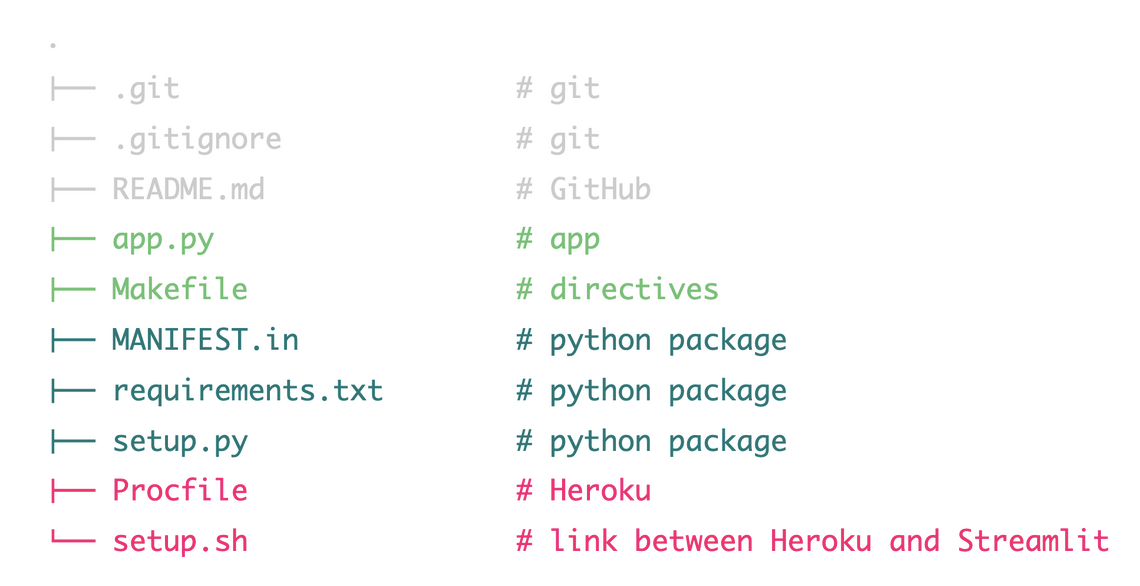

### app.py

In [ ]:
import streamlit as st

st.write('hello')

### Makefile

In [ ]:
run_streamlit:
    streamlit run app.py

### MANIFEST.in

In [ ]:
include requirements.txt

### requirements.txt

In [ ]:
streamlit

### setup.py

In [ ]:
from setuptools import setup, find_packages

with open("requirements.txt") as f:
    content = f.readlines()
requirements = [x.strip() for x in content]

setup(name="streamlitapp",
      version="1.0",
      description="streamlit app",
      packages=find_packages(),
      include_package_data=True,  # includes in package files from MANIFEST.in
      install_requires=requirements)

### Procfile

In [ ]:
web: sh setup.sh && streamlit run app.py

### setup.sh

In [ ]:
mkdir -p ~/.streamlit/

echo "\
[general]\n\
email = \"${HEROKU_EMAIL_ADDRESS}\"\n\
" > ~/.streamlit/credentials.toml

echo "\
[server]\n\
headless = true\n\
enableCORS = false\n\
port = $PORT\n\
" > ~/.streamlit/config.toml

### Deploying the app

In [ ]:
# upload your SSH key to Heroku (if not already done)
heroku keys:add ~/.ssh/id_ed25519.pub

# create the app in the EU region
heroku create APP_NAME --ssh-git --region eu

# you should see the origin remote for GitHub
# and the heroku remote for Heroku
git remote -v

# manually add the heroku remote if necessary
git remote add heroku https://git.heroku.com/APP_NAME.git

# deploy the app
git push heroku master

# start the web dyno
heroku ps:scale web=1

# check the logs for errors
heroku logs --tail

### File glossary

**.git**

git repository: source control main directory

if you erase this directory you loose all history of the commits unless they have been pushed to a remote repository (origin or other)

**.gitignore**

specific to git: lists the files to exclude from source control

for example you may want to ignore the python __pycache__ folders

**README.md**

optional: you may add here markdown information about the app for you coworkers

this will be displayed in the main page of your repository on GitHub

**MANIFEST.in**

contains the list of files that must be included or excluded from package deployment, in particular requirements.txt

usage must be declared in setup.py
**requirements.txt**

contains the pip packages required in order to run Streamlit and your script

if you setup a virtual env for your app, they can be obtained through a pip freeze

**setup.py**

describes the attributes of the app package (name, version, description)

the requirements pip packages for the app must be listed here as well

**app.py**

the main script of the app: the name can be anything but should correspond

to the content of the command in the Procfile

**Procfile**

specific to Heroku: indicates which type of process to run (web)

as well as the command to run in order to start the dyno (which can be customized)

**setup.sh**

custom script launched by the Procfile command

indicates to streamlit the app owner's email and Heroku's dynamically assigned port on which to run

**__pycache__**

cache directory generated by python when it runs the code

erasing this directory has no impact, it may be added to the .gitignore

**.ipynb_checkpoints**

temporary jupyter notebook directory generated whenever a notebook is created, store automatic notebook backups

erasing this directory has no impact, it may be added to the .gitignore
